<a href="https://colab.research.google.com/github/freakezoide/codigos-de-coolab/blob/main/KNN_vinos_mejor_K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Distribución de clases:
quality_category
0    0.803448
1    0.196552
Name: proportion, dtype: float64

Mejores parámetros encontrados: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Puntuaciones de validación cruzada (F1): [0.88463703 0.87769784 0.89900111 0.88495575 0.88839534]
Media F1 (CV): 0.8869374136882928

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1044
           1       0.56      0.80      0.66       256

    accuracy                           0.84      1300
   macro avg       0.75      0.82      0.78      1300
weighted avg       0.87      0.84      0.85      1300


Matriz de Confusión:
[[882 162]
 [ 51 205]]

Precisión: 0.8361538461538461
F1-score: 0.6581059390048154


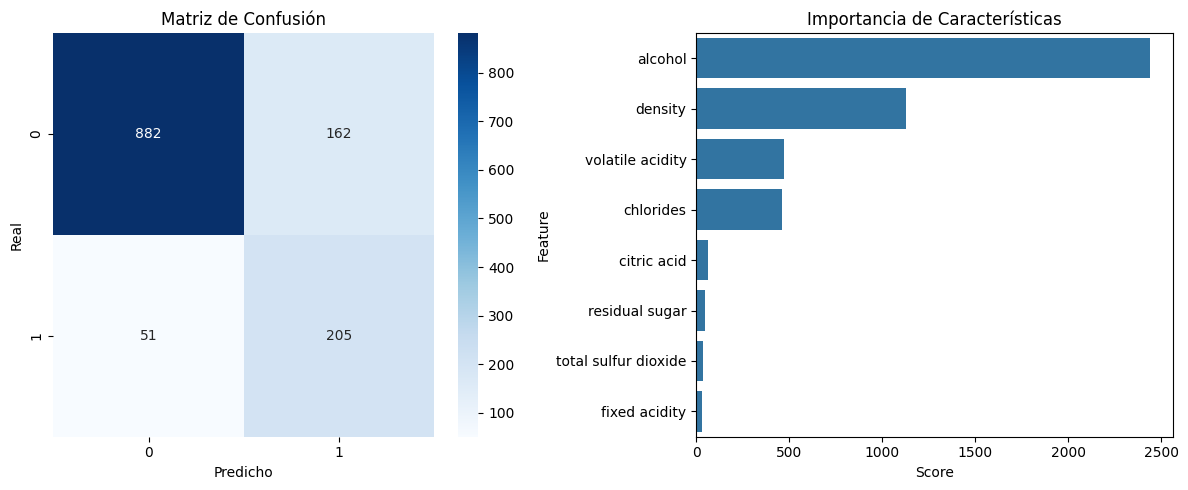

In [5]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import numpy as np

# Cargar los datos
df_red = pd.read_csv('winequality-red.csv', sep=';')
df_white = pd.read_csv('winequality-white.csv', sep=';')

# Añadir una columna para identificar el tipo de vino
df_red['type'] = 'red'
df_white['type'] = 'white'

# Combinar ambos datasets
df = pd.concat([df_red, df_white])

# Preprocesamiento
# Convertir la calidad en categorías binarias
df['quality_category'] = df['quality'].apply(lambda x: 1 if x >= 7 else 0)

# Ver distribución de clases
print("Distribución de clases:")
print(df['quality_category'].value_counts(normalize=True))

# Preparar datos
X = df.drop(['quality', 'quality_category', 'type'], axis=1)
y = df['quality_category']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Manejo de desbalance de clases con SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# 2. Selección de características
selector = SelectKBest(f_classif, k=8)
X_train_selected = selector.fit_transform(X_train_res, y_train_res)
X_test_selected = selector.transform(X_test)

# 3. Estandarización de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# 4. Optimización de hiperparámetros con GridSearchCV
param_grid = {
    'n_neighbors': range(3, 30, 2),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train_res)

# Mejor modelo
best_knn = grid_search.best_estimator_
print("\nMejores parámetros encontrados:", grid_search.best_params_)

# Evaluación con validación cruzada
cv_scores = cross_val_score(best_knn, X_train_scaled, y_train_res, cv=5, scoring='f1')
print("\nPuntuaciones de validación cruzada (F1):", cv_scores)
print("Media F1 (CV):", np.mean(cv_scores))

# Predicción en el conjunto de prueba
y_pred = best_knn.predict(X_test_scaled)

# Métricas de evaluación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nPrecisión:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

# Visualización
plt.figure(figsize=(12, 5))

# Matriz de confusión
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')

# Importancia de características
plt.subplot(1, 2, 2)
feature_scores = pd.DataFrame({
    'Feature': X.columns[selector.get_support()],
    'Score': selector.scores_[selector.get_support()]
}).sort_values('Score', ascending=False)
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.title('Importancia de Características')
plt.tight_layout()
plt.show()
